In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.core.sheet import Sheet

from tyssue import config
from tyssue.topology.sheet_topology import cell_division

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.dynamics.sheet_vertex_model import SheetModel as model

from tyssue.core.generation import extrude
from tyssue.core.monolayer import Monolayer, MonolayerWithLamina
from tyssue.geometry.bulk_geometry import BulkGeometry, MonoLayerGeometry
from tyssue.dynamics.bulk_model import BulkModel, LaminaModel, set_model
from tyssue.solvers.sheet_vertex_solver import Solver

from tyssue.draw.vispy_draw import vp_view

from tyssue.draw.plt_draw import sheet_view

from tyssue.topology.sheet_topology import remove_face
from tyssue.core.objects import get_opposite
from tyssue.io.hdf5 import save_datasets, load_datasets

from tyssue.topology.sheet_topology import face_division, get_division_edges


In [2]:
datasets = load_datasets('small_ellipsoid.hf5',
                         data_names=['vert', 'edge',
                                     'face', 'cell'])
specs = config.geometry.bulk_spec()

mono = Monolayer('ell', datasets, specs)
mono.reset_index()
mono.reset_topo()


# ## Settings for the quasi-static model
# ### Apical layer
apical_spec = {
    'edge': {
        'line_tension': 0.12,},
    'face': {
        'contractility': 0.04,
        'prefered_area': 0.8,
        'area_elasticity': 1.0},
    'cell': {
        'prefered_vol': 1.0,
        'vol_elasticity': 1.0},
    'settings': {
        'grad_norm_factor': 1.0,
        'nrj_norm_factor': 1.0},}

# ### Modifier for each segment of the stratum
modifiers = {
    'sagittal': {
        'edge': {
            'line_tension': 0.1},
        'face': {
            'contractility': 0.05,
            'prefered_area': 0.2}
    },
    'basal': {
        'edge': {
            'line_tension': 0.5},
        'face': {
            'contractility': 0.1,
            'prefered_area': 0.2}},
    }

set_model(mono, BulkModel, apical_spec, modifiers)


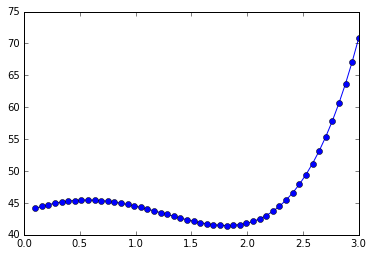

In [3]:
energies = []
deltas = np.linspace(0.1, 3)
for delta in deltas:
    BulkGeometry.scale(mono, delta,
                       mono.coords)
    BulkGeometry.update_all(mono)
    energies.append(BulkModel.compute_energy(mono))
    BulkGeometry.scale(mono, 1/delta,
                       mono.coords)
    BulkGeometry.update_all(mono)
    

fig, ax = plt.subplots()

ax.plot(deltas, energies, 'o-')

In [4]:
draw_specs = config.draw.sheet_spec()
canvas, view = vp_view(mono, **draw_specs)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)


In [5]:
res = Solver.find_energy_min(mono, BulkGeometry, BulkModel)

In [16]:
canvas, view = vp_view(mono)
monolayer = mono

In [19]:
img = canvas.render()
from vispy.io import imsave
imsave('ellipsoid.png', img)

In [7]:
mother = 15
mother_edges = monolayer.edge_df[
    monolayer.edge_df['cell'] == mother]
mother_faces = set(mother_edges['face'])

apical_face, = mother_edges[
    mother_edges['segment'] == 'apical']['face'].unique()

edge_a, edge_b = get_division_edges(monolayer, apical_face,
                                    BulkGeometry,
                                    angle=None, axis='x')
srce_a, trgt_a = mono.edge_df.loc[edge_a, ['srce', 'trgt']]
srce_b, trgt_b = mono.edge_df.loc[edge_b, ['srce', 'trgt']]

apical_daughter = face_division(monolayer, edge_a, edge_b)


In [15]:
sagittal_edges = mother_edges[
    mother_edges['segment'] == 'sagittal']
sagittal_faces = sagittal_edges['face'].unique()

s_edge_aa = sagittal_edges[(sagittal_edges['trgt'] == srce_a) &
                           (sagittal_edges['srce'] == trgt_a)].index[0]
s_edge_ab = sagittal_edges[(sagittal_edges['trgt'] == srce_b) &
                           (sagittal_edges['srce'] == trgt_b)].index[0]

s_face_a = int(monolayer.edge_df.loc[s_edge_aa,
                                     'face'])

s_face_b = int(monolayer.edge_df.loc[s_edge_ab,
                                     'face'])



In [23]:
sagittal_edges.loc[s_edge_a, 'face']

188

In [35]:
def get_basal_edge(monolayer, sagittal_edge):
    face = int(monolayer.edge_df.loc[sagittal_edge, 'face'])
    edges = monolayer.edge_df[
        monolayer.edge_df['face'] == face]
    srce_segments = monolayer.vert_df.loc[edges['srce'], 'segment']
    srce_segments.index = edges.index
    trgt_segments = monolayer.vert_df.loc[edges['trgt'], 'segment']
    trgt_segments.index = edges.index

    basal_edge, = edges[(srce_segments == 'basal') &
                        (trgt_segments == 'basal')].index
    return basal_edge


def opposite_face(eptm, face):
    vert_orbit = eptm.get_orbits('face', 'srce').groupby(
        level='face').apply(lambda df: set(df))
    print(vert_orbit.loc[face])
    opp_faces = vert_orbit[vert_orbit == vert_orbit.loc[face]].index
    print(opp_faces)
    if len(opp_faces) == 2:
        opp_face, = opp_faces[opp_faces != face]
        return opp_face
    else:
        return None


In [28]:
%pdb

Automatic pdb calling has been turned ON


In [37]:
s_face_a = int(monolayer.edge_df.loc[])


b_edge_a = get_basal_edge(monolayer, s_edge_a)
b_edge_b = get_basal_edge(monolayer, s_edge_b)



sagittal_daughter_a = face_division(monolayer,
                                    s_edge_a,
                                    b_edge_a)
sagittal_daughter_b = face_division(monolayer,
                                    s_edge_b,
                                    b_edge_b)



In [38]:
canvas, view = vp_view(mono)

In [52]:
vert_orbit = monolayer.get_orbits('face', 'srce').groupby(
    level='face').apply(lambda df: set(df))


In [58]:
vo = vert_orbit.loc[mono.sagittal_faces].head(10)
vo[vo == vo.loc[132]]

face
132    {1, 2, 93, 94}
133    {1, 2, 93, 94}
Name: srce, dtype: object

In [47]:
sagittal_faces

array([184, 185, 186, 187, 188, 393])

In [60]:
opposite_face(monolayer, sagittal_faces[0])

{16, 188, 108, 189}
Int64Index([184], dtype='int64', name='face')


In [61]:
fv = {16, 188, 108, 189}

vert_orbit[vert_orbit == fv]

face
184    {16, 188, 108, 189}
Name: srce, dtype: object

In [51]:
{64, 0, 2, 78, 1} == {64, 1, 2, 78, 0}

True